In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import time

In [2]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  64


In [3]:
## Read the data
data = pd.read_csv("./mydata/warfarin_dosing.csv")
data = data.sample(frac=1)
outcome_name = 'Therapeutic Dose of Warfarin' 
## Bin Outcomes
data['Low Dose'] = (data[outcome_name] < 3 * 7).astype(int)
data['Medium Dose'] = ((data[outcome_name] >= 3 * 7) & (data[outcome_name] <= 7 * 7)).astype(int)
data['Large Dose'] = (data[outcome_name] > 7 * 7).astype(int)
outcome_labels = ['Low Dose', 'Medium Dose', 'Large Dose']

true_doses_onehot = np.vstack([data['Low Dose'], data['Medium Dose'], data['Large Dose']]).T.astype(int)
true_doses = np.argmax(true_doses_onehot, axis=1)
data["Dose Index"] = true_doses
data.shape

(5700, 77)

In [4]:
### Creating feature set. ###
# Original paper by Consortium uses 17 features and gets within 8.5 mg/wk of stable dosage.

# First replace age bins (categorical) with age in decades (numerical)
data['Age'].replace(['10 - 19', '20 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79', '80 - 89', '90+'],
                   [1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
data['Age^2'] = data['Age'] ** 2
data['log(Age)'] = np.log(data['Age'])

# Enzyme inducer status
data['Enzyme inducer status'] = ((data['Carbamazepine (Tegretol)'] == 1) | (data['Phenytoin (Dilantin)'] == 1) \
    | (data['Rifampin or Rifampicin'] == 1)).astype(int)

# Taking amiodarone
data['Amiodarone'] = (data['Amiodarone (Cordarone)'] == 1).astype(int)

# Race
data['White'] = (data['Race (OMB)'] == 'White').astype(int)
data['Asian'] = (data['Race (OMB)'] == 'Asian').astype(int)
data['Black'] = (data['Race (OMB)'] == 'Black or African American').astype(int)
data['Mixed or Unknown'] = (data['Race (OMB)'] == 'Unknown').astype(int)

# Cyp2C9 genotype
data['Cyp2C9 *1/*1'] = (data['Cyp2C9 genotypes'] == "*1/*1").astype(int)
data['Cyp2C9 *1/*2'] = (data['Cyp2C9 genotypes'] == "*1/*2").astype(int)
data['Cyp2C9 *1/*3'] = (data['Cyp2C9 genotypes'] == "*1/*3").astype(int)
data['Cyp2C9 *2/*2'] = (data['Cyp2C9 genotypes'] == "*2/*2").astype(int)
data['Cyp2C9 *2/*3'] = (data['Cyp2C9 genotypes'] == "*2/*3").astype(int)
data['Cyp2C9 *3/*3'] = (data['Cyp2C9 genotypes'] == "*3/*3").astype(int)
data['Cyp2C9 unknown'] = (data['Cyp2C9 genotypes'].isna()).astype(int)

# VKORC1 genotype
data['VKORC1 A/A'] = (data['VKORC1 -1639 consensus'] == "A/A").astype(int)
data['VKORC1 A/G'] = (data['VKORC1 -1639 consensus'] == "A/G").astype(int)
data['VKORC1 unknown'] = (data['VKORC1 -1639 consensus'].isna()).astype(int)

feature_name_list = ['Age', 'Weight (kg)', 'Enzyme inducer status', 'Amiodarone', 'White', 'Asian', 'Black',
              'Mixed or Unknown', 'Cyp2C9 *1/*1', 'Cyp2C9 *1/*2', 'Cyp2C9 *1/*3', 'Cyp2C9 *2/*3', 'Cyp2C9 *3/*3',
              'Cyp2C9 unknown', 'VKORC1 A/A', 'VKORC1 A/G', 'VKORC1 unknown']

# Define target group as not 'White'
# data['targetgroup'] = 1 - data['White']
data['Male'] = (data['Gender'] == 'male').astype(int)

data_columns = feature_name_list + outcome_labels + ["Dose Index", 'Male']
selected_data = data[data_columns].dropna()
selected_data.shape

(5376, 22)

In [5]:
total_offline_pop = 500
offline_pop = selected_data[:total_offline_pop]
online_pop = selected_data[total_offline_pop:]

In [6]:
### Simulation Playground ###

## Find nearest neighbor ##
offline_pop_features = offline_pop[feature_name_list].to_numpy()
max_features = np.max(selected_data[feature_name_list]).to_numpy()
normalized_offline_pop_features = offline_pop_features / max_features

### Some Helper Functions ###
def logit(p):
    """ Domain: (0, 1), Range: (-inf, inf). """
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    """ Domain: (-inf, inf), Range: (0, 1). """
    exp_p = np.exp(p)
    return exp_p / (1 + exp_p)

def whiten(ary):
    return (ary - np.mean(ary, axis=0)) / np.std(ary, axis=0)

def rmse(yhat, y):
    return np.sqrt(np.mean((yhat - y)**2))

def get_offline_pop_MLE_reward_ests(models):
    """ Use model to compute MLE reward ests for the offline population. """
    # Manually compute probabilities for efficiency.
    logits = []
    for model in models:
        coeffs = model.coef_.T # column vector
        intercept = model.intercept_
        logits.append(offline_pop_features @ coeffs + intercept)
    logits = np.hstack(logits)
    MLE_reward_ests = inv_logit(logits)
    return MLE_reward_ests

### Computing Reward Ests from Data ###

def logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c):
    """ Use the inverse unnormalized covariance matrix to compute an exploration bonus. """
    bonuses = np.sqrt(np.array([(feature.reshape(1, -1) @ inv_unnorm_cov @ feature.reshape(-1, 1))[0]
                       for feature in offline_pop_features]))
        
#     rho_t = a + b * num_features/2 * np.log(1 + t/c)
    rho_t = 1 # shrink the confidence intervals for faster learning.
    return bonuses # * rho_t

def pointwise_opt_reward_ests(mle_rewards, inv_unnorm_cov, t, a=1, b=1, c=70): # default coeffs rough plug-in ests using theory
    return mle_rewards + logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c)
#     return logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c)
#     return get_offline_pop_MLE_reward_ests(model)
    
    
def get_nn(person):
    """ Return row # of offline individual most 'similar' to person, 
        using L2 (normalized) feature distance. """
    # compute person's comparison vector
    normalized_person_features = person[feature_name_list].to_numpy() / max_features
    l2_dists = np.linalg.norm(normalized_person_features-normalized_offline_pop_features, ord=2, axis=1)

    return np.argmin(l2_dists)

# Test nn
person = online_pop[150:151]
person, offline_pop.iloc[get_nn(person)]

(      Age  Weight (kg)  Enzyme inducer status  Amiodarone  White  Asian  \
 3842  4.0        121.4                      0           0      0      0   
 
       Black  Mixed or Unknown  Cyp2C9 *1/*1  Cyp2C9 *1/*2  ...  Cyp2C9 *3/*3  \
 3842      1                 0             1             0  ...             0   
 
       Cyp2C9 unknown  VKORC1 A/A  VKORC1 A/G  VKORC1 unknown  Low Dose  \
 3842               0           0           0               0         0   
 
       Medium Dose  Large Dose  Dose Index  Male  
 3842            1           0           1     1  
 
 [1 rows x 22 columns],
 Age                       5.0
 Weight (kg)              92.5
 Enzyme inducer status     0.0
 Amiodarone                0.0
 White                     0.0
 Asian                     0.0
 Black                     1.0
 Mixed or Unknown          0.0
 Cyp2C9 *1/*1              1.0
 Cyp2C9 *1/*2              0.0
 Cyp2C9 *1/*3              0.0
 Cyp2C9 *2/*3              0.0
 Cyp2C9 *3/*3              0.0

In [8]:
# Test how well-specified logistic regression is
online_pop_features = online_pop[feature_name_list].to_numpy()
online_pop_low_dose = online_pop[outcome_labels[0]]
online_pop_med_dose = online_pop[outcome_labels[1]]
online_pop_high_dose = online_pop[outcome_labels[2]]

oracle_model_low = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(
    online_pop_features, online_pop_low_dose)
acc_low = oracle_model_low.score(
    online_pop_features, online_pop_low_dose)

oracle_model_med = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(
    online_pop_features, online_pop_med_dose)
acc_med = oracle_model_med.score(
    online_pop_features, online_pop_med_dose)

oracle_model_high = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(
    online_pop_features, online_pop_high_dose)
acc_high = oracle_model_high.score(
    online_pop_features, online_pop_high_dose)

print(acc_low, acc_med, acc_high)

oracle_online_dose_probs = get_offline_pop_MLE_reward_ests(
    [oracle_model_low, oracle_model_med, oracle_model_high])

0.8008613617719442 0.6320754716981132 0.8929450369155045


In [9]:
### DGP Parameters ###
num_actions = 4
num_features = len(feature_name_list)

oracle_offline_dose_probs = get_offline_pop_MLE_reward_ests([oracle_model_low, oracle_model_med, oracle_model_high])
oracle_offline_dose_probs = np.hstack([oracle_offline_dose_probs, 
                                       np.ones((total_offline_pop, 1))])

warfarin_cost = 20
alternative_cost = 550
offline_pop_costs = np.vstack([np.ones(total_offline_pop) * warfarin_cost, 
                               np.ones(total_offline_pop) * warfarin_cost, 
                               np.ones(total_offline_pop) * warfarin_cost,
                               np.ones(total_offline_pop) * alternative_cost]).T
## Simulation ##

# Simulation parameters
per_person_budget = 50
warmup_batch_size = 50

def run_simulation(policy_optimizer, total_online_pop = 1000):
    np.random.seed() # set random seed for parallelization

    # Pretrain model with warmup batch. Make sure at least one male, one viet
    condition = True
    while condition:
        warmup_batch = online_pop.sample(warmup_batch_size)
        features = warmup_batch[feature_name_list].to_numpy()
        unnorm_cov = sum([np.outer(feature, feature) for feature in features])
        condition = np.linalg.matrix_rank(unnorm_cov) < num_features
    random_actions = np.random.randint(num_actions - 1, size=warmup_batch_size)
    outcomes = warmup_batch[outcome_labels].to_numpy(dtype=int)
    rewards = outcomes[np.arange(warmup_batch_size), random_actions] 
    data = np.hstack([warmup_batch.to_numpy(), random_actions.reshape(-1, 1)])
    models = [LogisticRegression(max_iter=int(1e4)).fit(features, outcomes[:, a]) for a in range(num_actions - 1)]

    inv_unnorm_cov = np.linalg.inv(sum([np.outer(feature, feature) for feature in features]))

    # Run simulation #
    est_utility_vals = []
    oracle_pihat_utility_vals = []
    oracle_pistar_utility_vals = []

    target_group_cum_expense, nontarget_group_cum_expense = 0, 0
    remaining_budget = per_person_budget * total_online_pop
    target_group_cum_expense_curve = []
    remaining_budget_curve = []
    avg_bonuses = [] 
    for t in tqdm(range(total_online_pop)):
        new_person = online_pop.sample(1)
        new_covariate = new_person[feature_name_list]

        # Compute the contextual policy and person-conditioned action distribution.
        mle_rewards = get_offline_pop_MLE_reward_ests(models)
        reward_ests = pointwise_opt_reward_ests(mle_rewards, inv_unnorm_cov, t)
        reward_ests = np.hstack([reward_ests, 
                                 np.ones((reward_ests.shape[0], 1))])
        reward_bonuses = logistic_exploration_bonus(inv_unnorm_cov, t, a=1, b=1, c=70)
        remaining_avg_budget = max(remaining_budget/(total_online_pop - t), 0)
        with warnings.catch_warnings(): # catch 'not DPP' warnings
            warnings.simplefilter("ignore")
            try:
                computed_policy, utility_fn, reward_params, problem = policy_optimizer(
                    reward_ests, max(remaining_avg_budget, warfarin_cost))
            except:
                computed_policy, utility_fn, reward_params, problem = policy_optimizer(
                    reward_ests, max(remaining_avg_budget, warfarin_cost), True)

        nn_id = get_nn(new_person)
        action_dist = computed_policy[nn_id, :]
        
        # Sample the action and reward
        try:
            action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
        except:
            action_dist /= sum(action_dist) # correct for rounding errors
            print(action_dist)
            action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
        
        # Compute cost of action
        action_cost = 0
        if action_taken <= 2:
            action_cost = warfarin_cost
            new_feature = new_person[feature_name_list].to_numpy().T
            new_outcome = new_person[outcome_labels].to_numpy(dtype=int).T
            features = np.vstack([features, new_feature.T])
            outcomes = np.vstack([outcomes, new_outcome.T])
            reward = new_outcome[action_taken]
            models = [LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(
                    features, outcomes[:, action]) for action in range(num_actions - 1)]

            # Update inverse unnorm cov matrix according to Sherman-Morrison formula.
            inv_unnorm_cov -= inv_unnorm_cov @ np.outer(new_feature, new_feature) @ inv_unnorm_cov / \
                                (1 + new_feature.T @ inv_unnorm_cov @ new_feature)
        elif action_taken == 3:
            action_cost = alternative_cost
            reward = [1]
        rewards = np.concatenate([rewards, reward])

        # Accumulate data
        est_utility_vals.append(utility_fn.value)
        reward_params.value = oracle_offline_dose_probs
        oracle_pihat_utility_vals.append(utility_fn.value)
        
        problem.solve()
        oracle_pistar_utility_vals.append(utility_fn.value)
        
        # Update remaining budget
        remaining_budget -= action_cost
        
        data = np.vstack([data, np.hstack([new_person.to_numpy(), [[action_taken]]])])

        remaining_budget_curve.append(remaining_budget)
    values = [est_utility_vals, oracle_pihat_utility_vals, oracle_pistar_utility_vals]
    return values, rewards, data, remaining_budget_curve, mle_rewards # avg_bonuses

simulation_columns = ['values', 'rewards', 'data', 'remaining_budget_curve', 'mle_rewards']

In [10]:
def compute_opt_policy_reward_max(reward_ests, budget, verbose=False):
    """ Compute policy which maximizes rewards. Takes as input reward estimates and budget constraint. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, num_actions), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, num_actions), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    utility_fn = faster_compile_param * exp_rew # for some reason multiplying by the param makes the problem compile faster??
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt_problem.solve(verbose=verbose)
    return policy_var.value, utility_fn, reward_params, opt_problem

# Define groups by age.
offline_age_group_indicators = [(offline_pop['Age'] < 7).to_numpy(),
                                (offline_pop['Age'] >= 7).to_numpy()]
age_group_names = ['<70', '>= 70']

def compute_opt_policy_L1_budget_fairness(reward_ests, budget, group_indicators, lambda_g=0.004):
    """ Compute policy which maximizes rewards + L1 budget fairness. 
    Takes as input reward estimates, budget constraint, and scaling param. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, num_actions), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, num_actions), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    lambda_g_param = cp.Parameter(nonneg=True)
    group_spendings = [cp.sum(avg_per_person_spending[gis])/np.sum(gis) for gis in group_indicators]
    L1_budget_fairness = sum([cp.abs(group_spending - average_expenditure) for group_spending in group_spendings])
    
    
    utility_fn = faster_compile_param*exp_rew - lambda_g_param * L1_budget_fairness
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    lambda_g_param.value = lambda_g

    opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem

def compute_opt_policy_L1_budget_fairness_age(reward_ests, budget):
    return compute_opt_policy_L1_budget_fairness(reward_ests, budget, offline_age_group_indicators, lambda_g=0.004)

In [11]:
def plotter_group(results, online_group_indicators, group_names):
    """ Plotting results for reference and debugging. Not for generating plots in paper. 
    Takes as input the indicators for different groups in the online population. """
    online_pop_size = len(results[0][3])
    num_groups = len(online_group_indicators)
    num_sims = len(results)
    total_budget = per_person_budget * online_pop_size

    
    # Oracle Utilities
    oracle_pihat_utility_vals = np.round(np.array(
        [result[simulation_columns.index('values')][1] for result in results]), 5)
    oracle_pistar_utility_vals = np.round(np.array(
        [result[simulation_columns.index('values')][2] for result in results]), 5)
    normalized_pihat_utility_vals = oracle_pihat_utility_vals / oracle_pistar_utility_vals
    mean_oracle_pihat_utility_vals = np.mean(normalized_pihat_utility_vals, axis=0)
    ste_oracle_pihat_utility_vals = stats.sem(normalized_pihat_utility_vals, axis=0)
    plt.plot(mean_oracle_pihat_utility_vals)
    h1 = plt.fill_between(np.arange(mean_oracle_pihat_utility_vals.shape[0]), 
                     mean_oracle_pihat_utility_vals-2*ste_oracle_pihat_utility_vals, 
                     mean_oracle_pihat_utility_vals+2*ste_oracle_pihat_utility_vals,
                    alpha=0.5)
    h2 = plt.axhline(y=1, c="r")
    plt.title("Oracle Utility")
    plt.ylabel("Utility/Optimal Utility")
    plt.legend(handles=[h1, h2], labels=["pi_hat", "pi_star"])
    plt.ylim([0.8, 1.01])
    

    online_pop_size = len(results[0][3])
    remaining_budget_curves = np.array([
        result[simulation_columns.index('remaining_budget_curve')] for result in results])

    spending_curves = np.hstack([total_budget * np.ones((num_sims, 1)), 
                                 remaining_budget_curves[:, :-1]]) - remaining_budget_curves

    group_cum_spending_curves = []
    cum_num_group_curves = []
    group_cum_reward_curves = [] 
    for online_group_indicator in online_group_indicators:
        group_cum_spending_curves.append(
            np.cumsum(spending_curves * online_group_indicator, axis=1))
        cum_num_group_curves.append(
            np.cumsum(online_group_indicator, axis=1))
        group_cum_reward_curves.append(
            np.cumsum(
                np.array([result[simulation_columns.index('rewards')][warmup_batch_size:] for result in results]) \
                      * online_group_indicator, axis=1))
    ## Cumulative Spending ##
    plt.figure()
    plt.title("Cumulative Spending")

    handles = []
    for g in range(num_groups):
        group_cum_spending_curve = group_cum_spending_curves[g]
        mean_group_cum_spending_curve = np.mean(group_cum_spending_curve, axis=0)
        ste_group_cum_spending_curve = stats.sem(group_cum_spending_curve, axis=0)
        plt.plot(mean_group_cum_spending_curve)
        handles.append(plt.fill_between(np.arange(mean_group_cum_spending_curve.shape[0]), 
                         mean_group_cum_spending_curve-2*ste_group_cum_spending_curve, 
                         mean_group_cum_spending_curve+2*ste_group_cum_spending_curve,
                        alpha=0.5))

    remaining_budget_curves = np.array([result[simulation_columns.index('remaining_budget_curve')] for result in results])
    overall_cum_spending_curves = per_person_budget*online_pop_size - remaining_budget_curves
    mean_overall_cum_spending_curve = np.mean(overall_cum_spending_curves, axis=0)
    ste_overall_cum_spending_curve = stats.sem(overall_cum_spending_curves, axis=0)
    plt.plot(mean_overall_cum_spending_curve)
    handles.append(
        plt.fill_between(np.arange(mean_overall_cum_spending_curve.shape[0]), 
                     mean_overall_cum_spending_curve-2*ste_overall_cum_spending_curve, 
                     mean_overall_cum_spending_curve+2*ste_overall_cum_spending_curve,
                    alpha=0.5))
    plt.legend(handles=handles, 
               labels=group_names + ["Overall"])

    ## Average per person spending between groups ##
    plt.figure()
    plt.title("Cumulative Average Spending Per Person")
    
    handles = []
    avg_spending_per_person_per_group = []
    for g in range(num_groups):
        avg_per_person_spending_group = group_cum_spending_curves[g] / cum_num_group_curves[g]
        mean_avg_per_person_spending_group = np.mean(avg_per_person_spending_group, axis=0)
        ste_avg_per_person_spending_group = stats.sem(avg_per_person_spending_group, axis=0)

        plt.plot(mean_avg_per_person_spending_group)
        handles.append(plt.fill_between(np.arange(mean_avg_per_person_spending_group.shape[0]), 
                         mean_avg_per_person_spending_group-2*ste_avg_per_person_spending_group, 
                         mean_avg_per_person_spending_group+2*ste_avg_per_person_spending_group,
                        alpha=0.5))
        avg_spending_per_person_per_group.append((mean_avg_per_person_spending_group[-1], 2*ste_avg_per_person_spending_group[-1]))
    plt.legend(handles=handles, labels=group_names)
    

    ## Cumulative realized reward between groups ##
    plt.figure()
    plt.title("Cumulative Realized Reward")
    handles = []
    for g in range(num_groups):
        handles.append(
            plt.plot(np.mean(group_cum_reward_curves[g], axis=0)))
    total_cum_reward_curves = np.array([
        np.cumsum(result[simulation_columns.index('rewards')][warmup_batch_size:]) for result in results])
    mean_total_cum_reward = np.mean(total_cum_reward_curves, axis=0)
    handles.append(plt.plot(mean_total_cum_reward))
    plt.legend(labels=group_names + ["Overall"])
    
    overall_avg_reward_per_person = (mean_total_cum_reward[-1] / online_pop_size, 2*stats.sem(total_cum_reward_curves[:, -1]))


    ## Average per person realized reward between groups ##
    plt.figure()
    plt.title("Average Realized Reward Per Person")

    handles = []
    avg_reward_per_person_per_group = []
    for g in range(num_groups):
        cum_avg_per_person_group_reward_curves = group_cum_reward_curves[g]/cum_num_group_curves[g]
        mean_avg_per_person_reward_group = np.mean(cum_avg_per_person_group_reward_curves, axis=0)
        ste_avg_per_person_reward_group = stats.sem(cum_avg_per_person_group_reward_curves, axis=0)
        plt.plot(mean_avg_per_person_reward_group)
        handles.append(plt.fill_between(np.arange(mean_avg_per_person_reward_group.shape[0]), 
                         mean_avg_per_person_reward_group-2*ste_avg_per_person_reward_group, 
                         mean_avg_per_person_reward_group+2*ste_avg_per_person_reward_group,
                        alpha=0.5))
        avg_reward_per_person_per_group.append((mean_avg_per_person_reward_group[-1], 2*ste_avg_per_person_spending_group[-1]))
    plt.legend(handles=handles, labels=group_names)
    plt.ylim([0, 1.01])
    
    return (avg_spending_per_person_per_group, avg_reward_per_person_per_group, overall_avg_reward_per_person)


In [21]:
## Reward Max Simulation ##
pool = mp.Pool(mp.cpu_count())
num_sims = 50

results_rew_max_1 = pool.starmap_async(run_simulation, [(compute_opt_policy_reward_max, 1000) for _ in range(num_sims)]).get()
pool.close()

pool = mp.Pool(mp.cpu_count())
num_sims = 50

results_rew_max_2 = pool.starmap_async(run_simulation, [(compute_opt_policy_reward_max, 1000) for _ in range(num_sims)]).get()
pool.close()

results_rew_max = results_rew_max_1 + results_rew_max_2

100%|██████████| 1000/1000 [02:28<00:00,  6.75it/s]


/tmp/ipykernel_59009/1345785719.py:84: RuntimeWarning: invalid value encountered in true_divide
  avg_per_person_spending_group = group_cum_spending_curves[g] / cum_num_group_curves[g]
/tmp/ipykernel_59009/1345785719.py:84: RuntimeWarning: invalid value encountered in true_divide
  avg_per_person_spending_group = group_cum_spending_curves[g] / cum_num_group_curves[g]
/tmp/ipykernel_59009/1345785719.py:120: RuntimeWarning: invalid value encountered in true_divide
  cum_avg_per_person_group_reward_curves = group_cum_reward_curves[g]/cum_num_group_curves[g]
/tmp/ipykernel_59009/1345785719.py:120: RuntimeWarning: invalid value encountered in true_divide
  cum_avg_per_person_group_reward_curves = group_cum_reward_curves[g]/cum_num_group_curves[g]


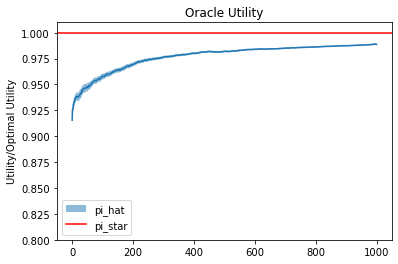

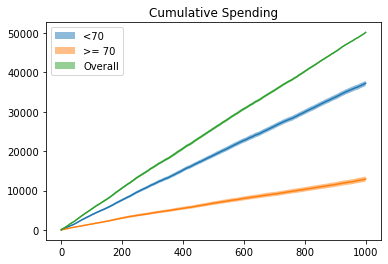

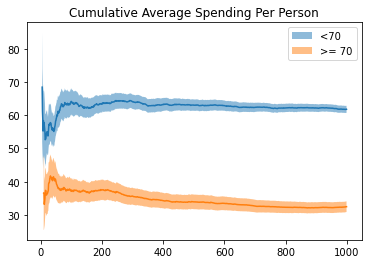

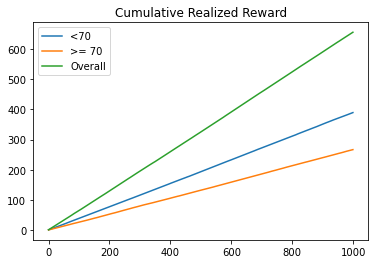

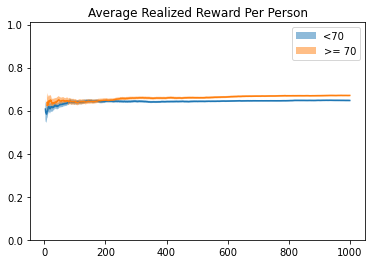

In [30]:
## Plot rew max data where groups are defined by ages. ##
online_age_group_inds_rew_max = [np.array([result[2][warmup_batch_size:, data_columns.index('Age')] < 7 
                                     for result in results_rew_max]),
                           np.array([result[2][warmup_batch_size:, data_columns.index('Age')] >= 7 
                                     for result in results_rew_max])]
age_group_names = ['<70', '>= 70']
realized_point_age_rew_max = plotter_group(results_rew_max, online_age_group_inds_rew_max, age_group_names)

In [22]:
## L1 Budget Fairness Age Simulation ##
pool = mp.Pool(mp.cpu_count())
num_sims = 50
results_L1_budget_fairness_age_1 = pool.starmap_async(run_simulation, [(compute_opt_policy_L1_budget_fairness_age, 1000) for _ in range(num_sims)]).get()
pool.close()

pool = mp.Pool(mp.cpu_count())
num_sims = 50
results_L1_budget_fairness_age_2 = pool.starmap_async(run_simulation, [(compute_opt_policy_L1_budget_fairness_age, 1000) for _ in range(num_sims)]).get()
pool.close()

results_L1_budget_fairness_age = results_L1_budget_fairness_age_1 + results_L1_budget_fairness_age_2

 97%|█████████▋| 970/1000 [04:00<00:06,  4.65it/s]/home/hyzhu/miniconda3/envs/scc/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 98%|█████████▊| 982/1000 [04:27<00:02,  6.22it/s]/home/hyzhu/miniconda3/envs/scc/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 1000/1000 [04:31<00:00,  3.68it/s]


/tmp/ipykernel_59009/1345785719.py:84: RuntimeWarning: invalid value encountered in true_divide
  avg_per_person_spending_group = group_cum_spending_curves[g] / cum_num_group_curves[g]
/tmp/ipykernel_59009/1345785719.py:84: RuntimeWarning: invalid value encountered in true_divide
  avg_per_person_spending_group = group_cum_spending_curves[g] / cum_num_group_curves[g]
/tmp/ipykernel_59009/1345785719.py:120: RuntimeWarning: invalid value encountered in true_divide
  cum_avg_per_person_group_reward_curves = group_cum_reward_curves[g]/cum_num_group_curves[g]
/tmp/ipykernel_59009/1345785719.py:120: RuntimeWarning: invalid value encountered in true_divide
  cum_avg_per_person_group_reward_curves = group_cum_reward_curves[g]/cum_num_group_curves[g]


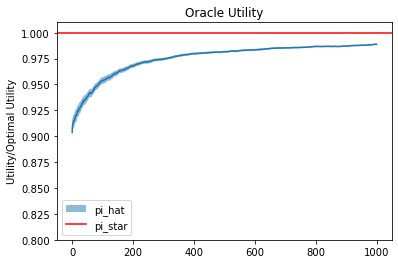

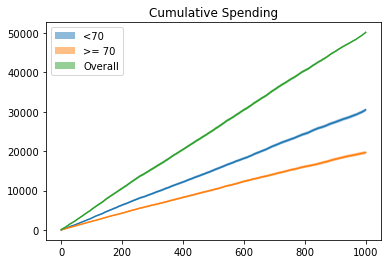

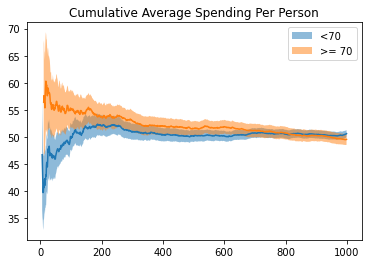

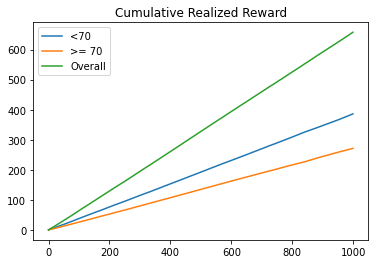

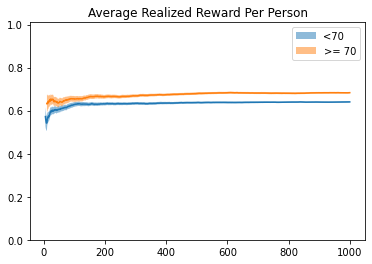

In [31]:
online_age_group_inds_L1_budget_fairness = [np.array([result[2][warmup_batch_size:, data_columns.index('Age')] < 7 
                                     for result in results_L1_budget_fairness_age]),
                           np.array([result[2][warmup_batch_size:, data_columns.index('Age')] >= 7 
                                     for result in results_L1_budget_fairness_age])]
age_group_names = ['<70', '>= 70']
realized_point_age_L1_budget_fairness_age = plotter_group(results_L1_budget_fairness_age, online_age_group_inds_L1_budget_fairness, age_group_names)

In [23]:
### Helper functions for generating paper plots. ###
# For reference `results' is composed of: (0, values), (1, rewards), (2, features), (3, target_group_cum_expense_curve), 
#          (4, remaining_budget_curve), (5, mle_rewards)
target_group_ids = offline_age_group_indicators[0]
nontarget_group_ids = offline_age_group_indicators[1]

def get_synthesis_points_final_expected(results, policy_optimizer):
    """ From results return mean and ste of 
    (final expected nontarget group $/person - target group $/person, 
     final expected target group rew/person, 
     final expected nontarget group rew/person,
     final expected total rew/person) under an average budget constraint. """
    final_mle_rewards = [result[simulation_columns.index('mle_rewards')] for result in results]
    
    overall_exp_rews_per_person = []
    target_group_rews_per_person = []
    nontarget_group_rews_per_person = []
    exp_spending_diffs = []
    
    for mle_reward_est in final_mle_rewards:
        mle_reward_est = np.hstack([mle_reward_est, 
                                 np.ones((mle_reward_est.shape[0], 1))])
        computed_policy, _, _, _ = policy_optimizer(mle_reward_est, per_person_budget)
        
        per_person_avg_spending = np.sum(np.multiply(offline_pop_costs, computed_policy), axis=1)
        exp_target_group_spending_per_person = np.mean(per_person_avg_spending[target_group_ids])
        exp_nontarget_group_spending_per_person = np.mean(per_person_avg_spending[nontarget_group_ids])
        
        per_person_avg_reward = np.sum(np.multiply(mle_reward_est, computed_policy), axis=1)
        exp_target_group_reward_per_person = np.mean(per_person_avg_reward[target_group_ids])
        exp_nontarget_group_reward_per_person = np.mean(per_person_avg_reward[nontarget_group_ids])
        exp_overall_reward_per_person = np.mean(per_person_avg_reward)
        
        exp_spending_diffs.append(exp_target_group_spending_per_person - exp_nontarget_group_spending_per_person)
        overall_exp_rews_per_person.append(exp_overall_reward_per_person)
        target_group_rews_per_person.append(exp_target_group_reward_per_person)
        nontarget_group_rews_per_person.append(exp_nontarget_group_reward_per_person)
    
    return ((np.mean(exp_spending_diffs), 2*stats.sem(exp_spending_diffs)),
            (np.mean(target_group_rews_per_person), 2*stats.sem(target_group_rews_per_person)),
            (np.mean(nontarget_group_rews_per_person), 2*stats.sem(nontarget_group_rews_per_person)),
            (np.mean(overall_exp_rews_per_person), 2*stats.sem(overall_exp_rews_per_person)))

def get_synthesis_points_final_realized(results, online_group_indicators):
    """ From results return mean and ste of 
    (Average realized nontarget group $/person - target group $/person, 
     Average realized target group rew/person, 
     Average realized nontarget group rew/person,
     Average realized total rew/person) under an average budget constraint. """
    online_pop_size = len(results[0][3])
    num_groups = len(online_group_indicators)
    num_sims = len(results)
    total_budget = per_person_budget * online_pop_size

    online_pop_size = len(results[0][3])
    remaining_budget_curves = np.array([
        result[simulation_columns.index('remaining_budget_curve')] for result in results])

    spending_curves = np.hstack([total_budget * np.ones((num_sims, 1)), 
                                 remaining_budget_curves[:, :-1]]) - remaining_budget_curves

    group_cum_spending_curves = []
    cum_num_group_curves = []
    group_cum_reward_curves = [] 
    for online_group_indicator in online_group_indicators:
        group_cum_spending_curves.append(
            np.cumsum(spending_curves * online_group_indicator, axis=1))
        cum_num_group_curves.append(
            np.cumsum(online_group_indicator, axis=1))
        group_cum_reward_curves.append(
            np.cumsum(
                np.array([result[simulation_columns.index('rewards')][warmup_batch_size:] for result in results]) \
                      * online_group_indicator, axis=1))
    ## Cumulative Spending ##
    remaining_budget_curves = np.array([result[simulation_columns.index('remaining_budget_curve')] for result in results])
    overall_cum_spending_curves = per_person_budget*online_pop_size - remaining_budget_curves
    spending_diffs_per_person = group_cum_spending_curves[0] / cum_num_group_curves[0] - group_cum_spending_curves[1] / cum_num_group_curves[1]
    mean_spending_diffs_per_person = np.mean(spending_diffs_per_person[:, -1])
    ste_spending_diffs_per_person = stats.sem(spending_diffs_per_person[:, -1])
    total_cum_reward_curves = np.array([
        np.cumsum(result[simulation_columns.index('rewards')][warmup_batch_size:]) for result in results])
    mean_total_cum_reward = np.mean(total_cum_reward_curves, axis=0)
    overall_avg_reward_per_person = (mean_total_cum_reward[-1] / online_pop_size, 2*stats.sem(total_cum_reward_curves[:, -1] / online_pop_size))

    ## Average per person realized reward between groups ##
    reward_diffs_per_person = group_cum_reward_curves[0]/cum_num_group_curves[0] - group_cum_reward_curves[1]/cum_num_group_curves[1]
    mean_reward_diffs_per_person = np.mean(reward_diffs_per_person[:, -1])
    ste_reward_diffs_per_person = stats.sem(reward_diffs_per_person[:, -1])
    mean_target_group_rew_per_person = np.mean((group_cum_reward_curves[0]/cum_num_group_curves[0])[:, -1])
    ste_target_group_rew_per_person = stats.sem((group_cum_reward_curves[0]/cum_num_group_curves[0])[:, -1])
    mean_nontarget_group_rew_per_person = np.mean((group_cum_reward_curves[1]/cum_num_group_curves[1])[:, -1])
    ste_nontarget_group_rew_per_person = stats.sem((group_cum_reward_curves[1]/cum_num_group_curves[1])[:, -1])
    return ((mean_spending_diffs_per_person, 2*ste_spending_diffs_per_person),
            (mean_target_group_rew_per_person, 2*ste_target_group_rew_per_person),
            (mean_nontarget_group_rew_per_person, 2*ste_nontarget_group_rew_per_person),
            overall_avg_reward_per_person)



0it [00:00, ?it/s]/tmp/ipykernel_59009/3418603189.py:72: RuntimeWarning: invalid value encountered in true_divide
  spending_diffs_per_person = group_cum_spending_curves[0] / cum_num_group_curves[0] - group_cum_spending_curves[1] / cum_num_group_curves[1]
/tmp/ipykernel_59009/3418603189.py:81: RuntimeWarning: invalid value encountered in true_divide
  reward_diffs_per_person = group_cum_reward_curves[0]/cum_num_group_curves[0] - group_cum_reward_curves[1]/cum_num_group_curves[1]
/tmp/ipykernel_59009/3418603189.py:84: RuntimeWarning: invalid value encountered in true_divide
  mean_target_group_rew_per_person = np.mean((group_cum_reward_curves[0]/cum_num_group_curves[0])[:, -1])
/tmp/ipykernel_59009/3418603189.py:85: RuntimeWarning: invalid value encountered in true_divide
  ste_target_group_rew_per_person = stats.sem((group_cum_reward_curves[0]/cum_num_group_curves[0])[:, -1])
/tmp/ipykernel_59009/3418603189.py:86: RuntimeWarning: invalid value encountered in true_divide
  mean_nontarge

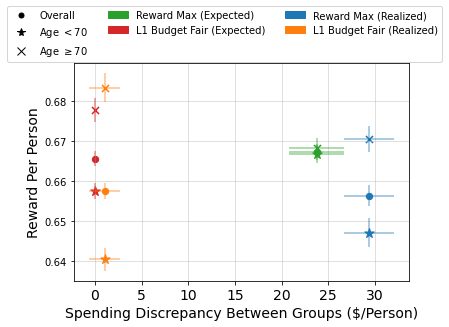

In [32]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### Generate realized/expected reward vs. spending plot in paper. ###
fig, ax = plt.subplots()
color_patches = []
total_results = [results_rew_max, results_L1_budget_fairness_age]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
color_index = 0
for results, online_groups_indicators, name in tqdm(zip(
        total_results,
        [online_age_group_inds_rew_max, online_age_group_inds_L1_budget_fairness],
        ["Reward Max (Realized)", "L1 Budget Fair (Realized)"]
    )):
    point = get_synthesis_points_final_realized(results, online_groups_indicators)
    color = colors[color_index]
    # Overall
    mean_spending_diffs = point[0][0]
    ste_spending_diffs = point[0][1]
    mean_overall_rew = point[3][0]
    ste_overall_rew = point[3][1]
    ax.scatter(mean_spending_diffs, mean_overall_rew, marker="o", color=color, s=40)
    plt.errorbar(mean_spending_diffs, mean_overall_rew, xerr=ste_spending_diffs, yerr=ste_overall_rew, color=color, alpha=0.5)

    # Target group
    mean_target_group_rew = point[1][0]
    ste_target_group_rew = point[1][1]

    ax.scatter(mean_spending_diffs, mean_target_group_rew, marker="*", color=color, s=100)
    plt.errorbar(mean_spending_diffs, mean_target_group_rew, xerr=ste_spending_diffs, yerr=ste_target_group_rew, color=color, alpha=0.5)

    # Nontarget group
    mean_nontarget_group_rew = point[2][0]
    ste_nontarget_group_rew = point[2][1]
    ax.scatter(mean_spending_diffs, mean_nontarget_group_rew, marker="x", color=color, s=50)
    plt.errorbar(mean_spending_diffs, mean_nontarget_group_rew, xerr=ste_spending_diffs, yerr=ste_nontarget_group_rew, color=color, alpha=0.5)
    
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1
    

for results, policy_optimizer, name in tqdm(zip(
        total_results,
        [compute_opt_policy_reward_max, compute_opt_policy_L1_budget_fairness_age],
        ["Reward Max (Expected)", "L1 Budget Fair (Expected)"]
    )):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        point = get_synthesis_points_final_expected(results, policy_optimizer)

    color = colors[color_index]
    # Overall
    ax.scatter(point[0][0], point[3][0], marker="o", color=color, s=40)
    plt.errorbar(point[0][0], point[3][0], xerr=point[0][1], yerr=point[3][1], color=color, alpha=0.5)

    # Target group
    ax.scatter(point[0][0], point[1][0], marker="*", color=color, s=100)
    plt.errorbar(point[0][0], point[1][0], xerr=point[0][1], yerr=point[1][1], color=color, alpha=0.5)

    # Nontarget group
    ax.scatter(point[0][0], point[2][0], marker="x", color=color, s=50)
    plt.errorbar(point[0][0], point[2][0], xerr=point[0][1], yerr=point[2][1], color=color, alpha=0.5)
    
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1
    



lgd = ax.legend(handles= [mlines.Line2D([], [], color='black', marker='o', linestyle='None', 
                                                 markersize=5, label='Overall'), 
                                   mlines.Line2D([], [], color='black', marker='*', linestyle='None', 
                                                 markersize=8, label=r'Age $<70$'), 
                                   mlines.Line2D([], [], color='black', marker='x', linestyle='None', 
                                                 markersize=8, label=r'Age $\geq70$')] + color_patches[2:] + color_patches[:2],
          bbox_to_anchor=(0, 1.185, 0.9, 0.1), loc=9, ncol=3)
plt.ylabel("Reward Per Person", fontsize=14)
plt.xlabel("Spending Discrepancy Between Groups ($/Person)", fontsize=14)
plt.xticks(fontsize=14)
plt.grid(alpha=0.5)
plt.savefig("warfarin_comparison_plot.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

2it [00:04,  2.23s/it]


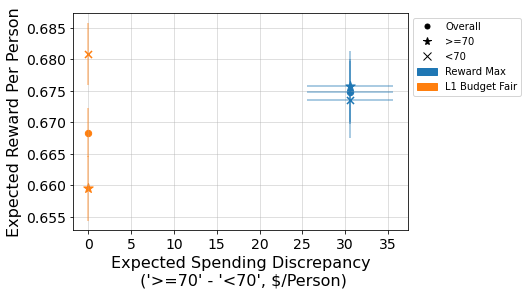

In [124]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
### Final Expected Synthesis Plot ###
fig, ax = plt.subplots()
color_patches = []
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
total_results = [results_rew_max, results_L1_budget_fairness_age]
color_index = 0
for results, policy_optimizer, name in tqdm(zip(
        total_results,
        [compute_opt_policy_reward_max, compute_opt_policy_L1_budget_fairness_age],
        ["Reward Max", "L1 Budget Fair"]
    )):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        point = get_synthesis_points_final_expected(results, policy_optimizer)

    color = colors[color_index]
    # Overall
    ax.scatter(point[0][0], point[3][0], marker="o", color=color, s=40)
    plt.errorbar(point[0][0], point[3][0], xerr=point[0][1], yerr=point[3][1], color=color, alpha=0.5)

    # Target group
    ax.scatter(point[0][0], point[1][0], marker="*", color=color, s=100)
    plt.errorbar(point[0][0], point[1][0], xerr=point[0][1], yerr=point[1][1], color=color, alpha=0.5)

    # Nontarget group
    ax.scatter(point[0][0], point[2][0], marker="x", color=color, s=50)
    plt.errorbar(point[0][0], point[2][0], xerr=point[0][1], yerr=point[2][1], color=color, alpha=0.5)
    
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1
    
lgd = ax.legend(handles=[mlines.Line2D([], [], color='black', marker='o', linestyle='None', 
                                                 markersize=5, label='Overall'), 
                                   mlines.Line2D([], [], color='black', marker='*', linestyle='None', 
                                                 markersize=8, label='>=70'), 
                                   mlines.Line2D([], [], color='black', marker='x', linestyle='None', 
                                                 markersize=8, label='<70')] + color_patches,
          bbox_to_anchor=(1, 1))
plt.ylabel("Expected Reward Per Person", fontsize=16)
plt.xlabel("Expected Spending Discrepancy\n ('>=70' - '<70', $/Person)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.5)
plt.savefig("warfarin_expected_comparison_plot.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

0it [00:00, ?it/s]/tmp/ipykernel_173477/2248773405.py:30: RuntimeWarning: invalid value encountered in true_divide
  spending_diffs_per_person = group_cum_spending_curves[0] / cum_num_group_curves[0] - group_cum_spending_curves[1] / cum_num_group_curves[1]
/tmp/ipykernel_173477/2248773405.py:39: RuntimeWarning: invalid value encountered in true_divide
  reward_diffs_per_person = group_cum_reward_curves[0]/cum_num_group_curves[0] - group_cum_reward_curves[1]/cum_num_group_curves[1]
/tmp/ipykernel_173477/2248773405.py:42: RuntimeWarning: invalid value encountered in true_divide
  mean_target_group_rew_per_person = np.mean((group_cum_reward_curves[0]/cum_num_group_curves[0])[:, -1])
/tmp/ipykernel_173477/2248773405.py:43: RuntimeWarning: invalid value encountered in true_divide
  ste_target_group_rew_per_person = stats.sem((group_cum_reward_curves[0]/cum_num_group_curves[0])[:, -1])
/tmp/ipykernel_173477/2248773405.py:44: RuntimeWarning: invalid value encountered in true_divide
  mean_non

(25, 1000)
(25, 1000)


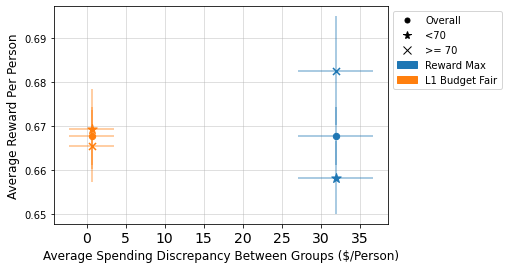

In [137]:
### Realized Synthesis Plot ###
fig, ax = plt.subplots()
color_patches = []
cmap = plt.get_cmap("gist_rainbow")

color_index = 0
total_results = [results_rew_max, results_L1_budget_fairness_age]
color_index = 0
for reults, online_groups_indicators, name in tqdm(zip(
        total_results,
        [online_age_group_inds_rew_max, online_age_group_inds_L1_budget_fairness],
        ["Reward Max", "L1 Budget Fair"]
    )):
    point = get_synthesis_points_final_realized(results, online_groups_indicators)
    color = colors[color_index]
    # Overall
    mean_spending_diffs = point[0][0]
    ste_spending_diffs = point[0][1]
    mean_target_group_rew = point[1][0]
    ste_target_group_rew = point[1][1]
    mean_nontarget_group_rew = point[2][0]
    ste_nontarget_group_rew = point[2][1]
    mean_overall_rew = point[3][0]
    ste_overall_rew = point[3][1]
    ax.scatter(mean_spending_diffs, mean_overall_rew, marker="o", color=color, s=40)
    plt.errorbar(mean_spending_diffs, mean_overall_rew, xerr=ste_spending_diffs, yerr=ste_overall_rew, color=color, alpha=0.5)

    # Target group
    ax.scatter(mean_spending_diffs, mean_target_group_rew, marker="*", color=color, s=100)
    plt.errorbar(mean_spending_diffs, mean_target_group_rew, xerr=ste_spending_diffs, yerr=ste_target_group_rew, color=color, alpha=0.5)

    # Nontarget group
    ax.scatter(mean_spending_diffs, mean_nontarget_group_rew, marker="x", color=color, s=50)
    plt.errorbar(mean_spending_diffs, mean_nontarget_group_rew, xerr=ste_spending_diffs, yerr=ste_nontarget_group_rew, color=color, alpha=0.5)
    
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1

lgd = ax.legend(handles=[mlines.Line2D([], [], color='black', marker='o', linestyle='None', 
                                                 markersize=5, label='Overall'), 
                                   mlines.Line2D([], [], color='black', marker='*', linestyle='None', 
                                                 markersize=8, label=age_group_names[0]), 
                                   mlines.Line2D([], [], color='black', marker='x', linestyle='None', 
                                                 markersize=8, label=age_group_names[1])] + color_patches,
          bbox_to_anchor=(1, 1))
plt.ylabel("Average Reward Per Person", fontsize=12)
plt.xlabel("Average Spending Discrepancy Between Groups ($/Person)", fontsize=12)
plt.xticks(fontsize=14)
plt.grid(alpha=0.5)
plt.savefig("scc_realized_comparison_plot.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')